In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#1. Load & Clean Data

file_path = "C:/Users/CHUMKI/Desktop/AA/Diabetes.xlsx"
df = pd.read_excel(file_path, sheet_name='Data')

 #Drop specified columns
cols_to_drop = ["encounter_id", "patient_nbr", "max_glu_serum", 
                "A1Cresult", "examide", "citoglipton", 
                "acetohexamide", "troglitazone"]
df.drop(columns=cols_to_drop, inplace=True)

 #Handle missing values
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [3]:
# ----------------------
# 2. Preprocessing
# ----------------------
X = df.drop(columns=["Readmission"])
y = df["Readmission"].astype(int)

# Categorical encoding
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)

# Class balancing
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_processed, y)

# ----------------------
# 3. Train/Val/Test Split
# ----------------------
# Split into labeled (train/val) and unlabeled (simulated for example)
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.3, random_state=42  # 30% as unlabeled
)

# Split labeled into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_labeled, y_labeled,
    test_size=0.2, stratify=y_labeled, random_state=42
)
# Split original data for final test
_, X_test, _, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2, stratify=y_resampled, random_state=42
)

In [5]:
# ----------------------
# 4. Feature Scaling
# ----------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_unlabeled = scaler.transform(X_unlabeled)  # Scale unlabeled data


In [7]:
# 5. Model Architecture
# ----------------------
def build_enhanced_model(input_dim):
    inputs = Input(shape=(input_dim,))
    
    # Block 1
    x = Dense(256, activation='swish', kernel_initializer='he_normal', 
          kernel_regularizer=tf.keras.regularizers.l2(5e-4))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    
    # Block 2 with residual
    residual = Dense(128, activation='swish')(x)
    x = Dense(128, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(residual)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Block 3 with projected residual
    x = Dense(64, activation='swish')(x)
    res_proj = Dense(64)(residual)  # Project residual to match dimensions
    x = tf.keras.layers.add([x, res_proj])
    x = Dropout(0.3)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)
model = build_enhanced_model(X_train.shape[1])
optimizer = Adam(learning_rate=1e-3, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['auc'])

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_auc',  # Reduce LR when val_auc stops improving
    factor=0.8,  # Reduce LR by 20%
    patience=5,  # Wait 5 epochs before reducing LR
    min_lr=1e-5,  # Don't reduce below this
    verbose=1
)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_auc',  # Stop training when validation AUC stops improving
    patience=7,  # Wait 7 epochs before stopping
    restore_best_weights=True  # Load the best model after stopping
)


In [13]:
from sklearn.utils import shuffle

# ----------------------
# 6. Semi-Supervised Training
# ----------------------
pseudo_history = []
best_auc = 0

for epoch in range(100):
    # Phase 1: Supervised Warmup
    if epoch < 10:
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=64,
            epochs=1,
            verbose=0
        )
        continue
    
    # Phase 2: Generate Pseudo-Labels
    pseudo_probs = model.predict(X_unlabeled, verbose=0).flatten()
    conf_threshold = 0.7 + min(0.15, epoch/200)
    mask = (pseudo_probs > conf_threshold) | (pseudo_probs < (1 - conf_threshold))
    
    # Create pseudo-labels
    pseudo_labels = (pseudo_probs[mask] > 0.5).astype(int)
    X_pseudo = X_unlabeled[mask]

    
 # Balance pseudo-labeled data
    n_pos = np.sum(pseudo_labels == 1)
    n_neg = np.sum(pseudo_labels == 0)
    n_samples = min(n_pos, n_neg)
    if n_samples == 0: continue
    
    idx_pos = np.random.choice(np.where(pseudo_labels == 1)[0], n_samples, replace=False)
    idx_neg = np.random.choice(np.where(pseudo_labels == 0)[0], n_samples, replace=False)
    X_balanced = np.concatenate([X_pseudo[idx_pos], X_pseudo[idx_neg]])
    y_balanced = np.concatenate([np.ones(n_samples), np.zeros(n_samples)])
    
    # Combine with labeled data
    X_combined = np.concatenate([X_train, X_balanced])
    y_combined = np.concatenate([y_train, y_balanced])
    
    # Shuffle combined data
    X_combined, y_combined = shuffle(X_combined, y_combined, random_state=epoch)
    
    # Phase 3: Train on Combined Data
history = model.fit(
    X_combined, y_combined,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=100,  # Maximum, but early stopping will stop earlier
    verbose=0,
    callbacks=[early_stopping, lr_scheduler]  # Add the callbacks here
)

    



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.00010737419361248613.

Epoch 56: ReduceLROnPlateau reducing learning rate to 8.589935605414213e-05.

Epoch 61: ReduceLROnPlateau reducing learning rate to 6.871948717162013e-05.

Epoch 66: ReduceLROnPlateau reducing learning rate to 5.497

In [14]:
 # Phase 4: Validation & Early Stopping
    
# Early stopping logic inside the training loop
for epoch in range(100):  
    # Training phase
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=1, verbose=0)

    # Phase 4: Validation & Early Stopping
    val_auc = history.history['val_auc'][0]  
    pseudo_history.append(val_auc)  

    # Save best model weights
    if val_auc > best_auc:  
        best_auc = val_auc  
        model.save_weights('best_model.weights.h5')  

    # Early stopping condition
    if len(pseudo_history) > 10 and np.argmax(pseudo_history[-10:]) == 0:  
        print("Early stopping triggered")
        break  # This is now correctly placed inside the loop

# Load best weights after training completes
model.load_weights('best_model.weights.h5')  


Early stopping triggered


In [17]:
# ----------------------
# 7. Evaluation
# ----------------------
y_pred = model.predict(X_test).flatten()
y_pred_class = (y_pred > 0.5).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
auroc = roc_auc_score(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"AUROC: {auroc:.2f}")


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Accuracy: 0.93
Precision: 0.90
Recall: 0.98
F1-score: 0.94
AUROC: 0.98


In [19]:
# Training Set Performance
y_train_pred = model.predict(X_train).flatten()
y_train_class = (y_train_pred > 0.5).astype(int)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_class):.2f}")
print(f"Train AUC: {roc_auc_score(y_train, y_train_pred):.2f}")

# Validation Set Performance
y_val_pred = model.predict(X_val).flatten()
y_val_class = (y_val_pred > 0.5).astype(int)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_class):.2f}")
print(f"Validation AUC: {roc_auc_score(y_val, y_val_pred):.2f}")

# Test Set Performance
y_test_pred = model.predict(X_test).flatten()
y_test_class = (y_test_pred > 0.5).astype(int)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_class):.2f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_pred):.2f}")


3165/3165 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Train Accuracy: 0.97
Train AUC: 1.00
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Validation Accuracy: 0.89
Validation AUC: 0.96
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Test Accuracy: 0.93
Test AUC: 0.98


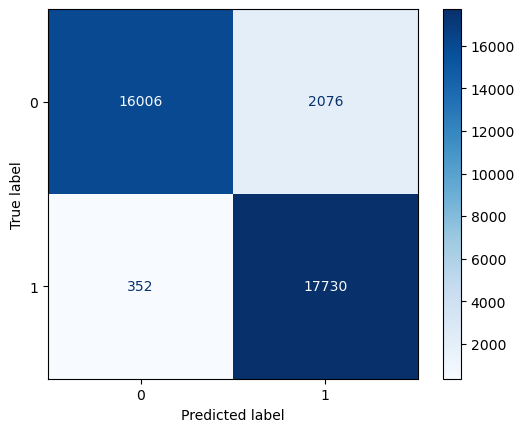

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


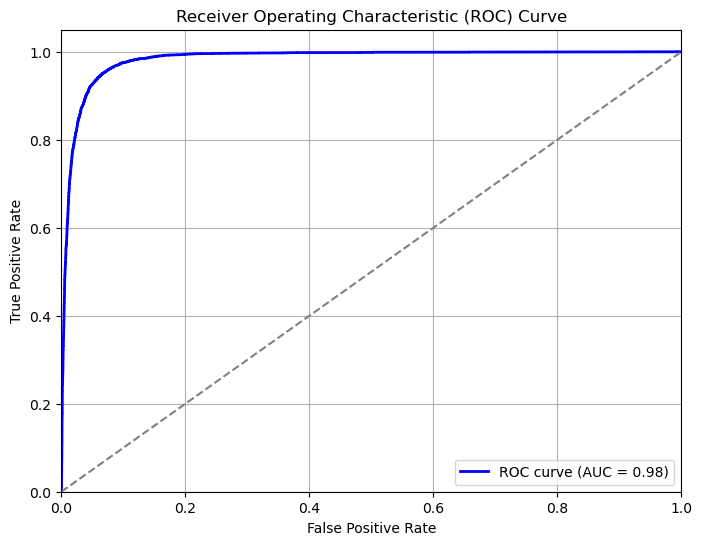

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities
y_pred_prob = model.predict(X_test).flatten()

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()



In [31]:
import nbformat
from docx import Document
\]
# Load the Jupyter Notebook
notebook_path = "Updated Model.ipynb"  # Change to your notebook's filename
word_output_path = "Updated Model.docx"

# Read the notebook
with open(notebook_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Create a new Word document
doc = Document()
doc.add_heading("Extracted Code from Notebook", level=1)

# Extract and add code cells to the document
for cell in nb['cells']:
    if cell['cell_type'] == 'code':
        doc.add_heading("Code Cell", level=2)
        doc.add_paragraph(cell['source'])

# Save the document
doc.save("C:/Users/CHUMKI/Desktop/AA/Updated Model1.docx")

print(f"Notebook code saved to: {"C:/Users/CHUMKI/Desktop/AA/Updated Model1.docx"}")


Notebook code saved to: C:/Users/CHUMKI/Desktop/AA/Updated Model1.docx


In [67]:
import nbformat
from nbconvert import PDFExporter

# Corrected file reading with UTF-8 encoding
notebook_filename = "Updated Model.ipynb"
with open(notebook_filename, encoding="utf-8") as f:
    notebook_content = nbformat.read(f, as_version=4)

# Convert to PDF
pdf_exporter = PDFExporter()
pdf_data, _ = pdf_exporter.from_notebook_node(notebook_content)

# Save as PDF
with open("Updated_Model.pdf", "wb") as pdf_file:
    pdf_file.write(pdf_data)

print("Notebook successfully converted to PDF!")



Notebook successfully converted to PDF!


In [69]:
# Rebuild model with explicit layer names
def build_enhanced_model(input_dim):
    inputs = Input(shape=(input_dim,), name='Input')
    
    # Block 1
    x = Dense(256, activation='swish', name='Dense_256')(inputs)
    x = BatchNormalization(name='BN_256')(x)
    x = Dropout(0.2, name='Dropout_20')(x)
    
    # ... [rest of your architecture] ...

# Generate enhanced visualization
plot_model(model, show_shapes=True, show_layer_activations=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [71]:
import tensorflow as tf
from datetime import datetime

# Create logs directory
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Write model graph
writer = tf.summary.create_file_writer(log_dir)
tf.summary.trace_on(graph=True)
with writer.as_default():
    tf.summary.trace_export(
        name="model_trace",
        step=0,
        profiler_outdir=log_dir
    )

# Launch TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [73]:
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(
    model,
    legend=True,  # Show layer names
    scale_xy=1.5, # Scaling factor
    font=ImageFont.truetype("arial.ttf", 16)  # Font settings
).show()

C:\Users\CHUMKI\anaconda3\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
